# 11. Hyperparameter Tuning (XGBoost)

## Objective
Optimize the hyperparameters of the XGBoost model using the **advanced feature set** to maximize ROC-AUC and F1-Score.

## Inputs
- `trajectory_ml_ready_advanced.csv`

## Strategy
1.  **Load Data**: Use the advanced dataset.
2.  **Preprocessing**: Same as before (SMOTE, Scaling not needed for trees but good for pipeline consistency).
3.  **Randomized Search**: Efficiently search a wide parameter space.
    *   `n_estimators`: [100, 200, 300, 500]
    *   `max_depth`: [3, 5, 7, 10]
    *   `learning_rate`: [0.01, 0.05, 0.1, 0.2]
    *   `subsample`: [0.6, 0.8, 1.0]
    *   `colsample_bytree`: [0.6, 0.8, 1.0]
    *   `scale_pos_weight`: [1, 3, 5] (To help with class imbalance)
4.  **Evaluation**: Compare the tuned model against the default advanced model.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# Set plot style
sns.set(style="whitegrid")

## 1. Load and Prepare Data

In [5]:
df = pd.read_csv('../trajectory_ml_ready_advanced.csv')

# Drop identifiers
drop_cols = ['UNITID', 'Institution_Name', 'Year', 'Target_Trajectory', 'Target_Label', 'State']
X = df.drop(columns=drop_cols)
y = df['Target_Label']

# Encode categorical variables
X = pd.get_dummies(X, columns=['Division'], drop_first=True)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f"Training Shape: {X_train.shape}")

Training Shape: (9643, 22)


## 2. Hyperparameter Tuning (RandomizedSearchCV)

In [6]:
# Define the pipeline
pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42))
])

# Define the parameter grid
param_grid = {
    'xgb__n_estimators': [100, 200, 300, 400],
    'xgb__max_depth': [3, 4, 5, 6, 8],
    'xgb__learning_rate': [0.01, 0.03, 0.05, 0.1, 0.2],
    'xgb__subsample': [0.7, 0.8, 0.9, 1.0],
    'xgb__colsample_bytree': [0.7, 0.8, 0.9, 1.0],
    'xgb__min_child_weight': [1, 3, 5]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=20, # Number of combinations to try
    scoring='roc_auc_ovr',
    cv=3,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

# Fit the model
print("Starting Hyperparameter Tuning...")
random_search.fit(X_train, y_train)

print("\nBest Parameters found:")
print(random_search.best_params_)
print(f"Best CV ROC-AUC: {random_search.best_score_:.4f}")

Starting Hyperparameter Tuning...
Fitting 3 folds for each of 20 candidates, totalling 60 fits


/Users/abnerlusung/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:07:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abnerlusung/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:07:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abnerlusung/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning: [17:07:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/abnerlusung/PycharmProjects/PythonProject/.venv/lib/python3.12/site-packages/xgboost/training.py:199: UserWarning:


Best Parameters found:
{'xgb__subsample': 0.7, 'xgb__n_estimators': 300, 'xgb__min_child_weight': 3, 'xgb__max_depth': 3, 'xgb__learning_rate': 0.05, 'xgb__colsample_bytree': 0.9}
Best CV ROC-AUC: 0.6996


## 3. Evaluate Best Model

--- Tuned XGBoost Performance ---
              precision    recall  f1-score   support

         0.0       0.62      0.26      0.37       944
         1.0       0.63      0.68      0.66      1139
         2.0       0.26      0.62      0.37       328

    accuracy                           0.51      2411
   macro avg       0.51      0.52      0.46      2411
weighted avg       0.58      0.51      0.50      2411

Test ROC-AUC Score: 0.6992


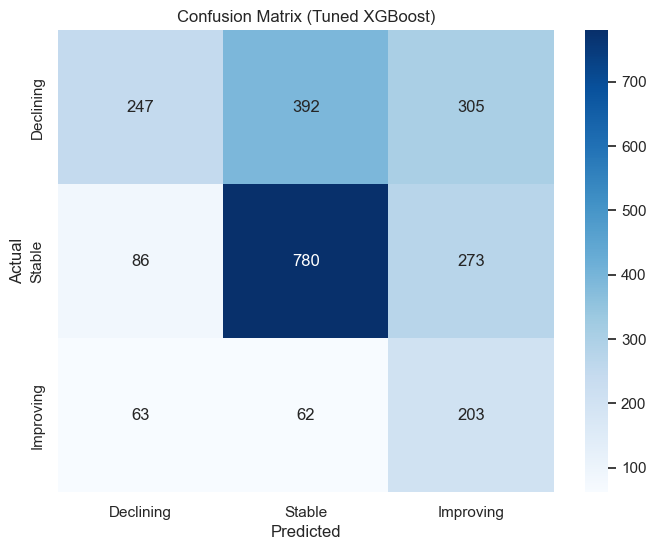

In [7]:
best_model = random_search.best_estimator_

y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)

print("--- Tuned XGBoost Performance ---")
print(classification_report(y_test, y_pred))

try:
    auc = roc_auc_score(y_test, y_prob, multi_class='ovr')
    print(f"Test ROC-AUC Score: {auc:.4f}")
except ValueError:
    print("Could not calculate ROC-AUC")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Declining', 'Stable', 'Improving'], yticklabels=['Declining', 'Stable', 'Improving'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Tuned XGBoost)')
plt.show()